<a href="https://colab.research.google.com/github/Onmang/Multimedia_engineering/blob/master/T20ME022_0616.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 118.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorfl

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pathlib # 階層構造にあるファイルを取得するためのライブラリ。globでもよいが勉強のため違うライブラリを使ってみます。
import matplotlib.pyplot as plt # グラフを書くためのライブラリ
import numpy as np # NumPy
import tensorflow as tf # tensorflow
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.regularizers import l2 # L2正則化
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.sequence import pad_sequences # for ゼロパディング用

In [ ]:
!unzip /content/drive/MyDrive/tennis.zip

In [3]:
# swingデータのリストを作成する関数（今回はPathライブラリを使っています。globでも構いません）
def mk_file_list(base_dir):
    path_base_dir = pathlib.Path(base_dir) # ファイルが置いてある場所のパスをセットする
    return [str(p) for p in sorted(path_base_dir.glob('*.txt'))] # データのファイルリストを取得する

train_list = mk_file_list('data/train') # 訓練データのリスト作成
valid_list = mk_file_list('data/valid') # 検証データのリスト作成
print(train_list)

['data/train/A_01.txt', 'data/train/A_02.txt', 'data/train/A_03.txt', 'data/train/A_04.txt', 'data/train/A_05.txt', 'data/train/A_06.txt', 'data/train/A_07.txt', 'data/train/A_08.txt', 'data/train/A_09.txt', 'data/train/A_11.txt', 'data/train/A_12.txt', 'data/train/A_13.txt', 'data/train/A_14.txt', 'data/train/A_15.txt', 'data/train/A_16.txt', 'data/train/A_17.txt', 'data/train/A_18.txt', 'data/train/A_19.txt', 'data/train/A_21.txt', 'data/train/A_22.txt', 'data/train/A_23.txt', 'data/train/A_24.txt', 'data/train/A_25.txt', 'data/train/A_26.txt', 'data/train/A_27.txt', 'data/train/A_28.txt', 'data/train/A_29.txt', 'data/train/A_31.txt', 'data/train/A_32.txt', 'data/train/A_33.txt', 'data/train/A_34.txt', 'data/train/A_35.txt', 'data/train/A_36.txt', 'data/train/A_37.txt', 'data/train/A_38.txt', 'data/train/A_39.txt', 'data/train/A_41.txt', 'data/train/A_42.txt', 'data/train/A_43.txt', 'data/train/A_44.txt', 'data/train/A_45.txt', 'data/train/A_46.txt', 'data/train/A_47.txt', 'data/trai

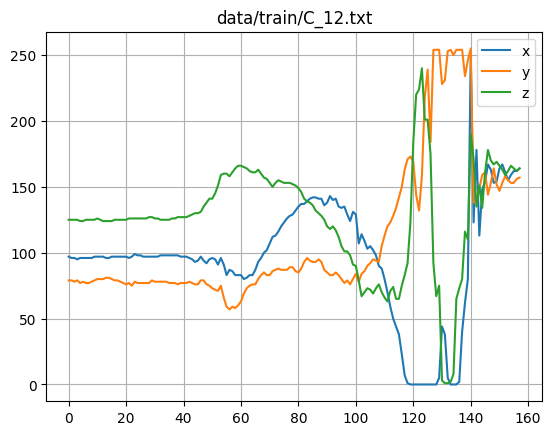

In [4]:
# 試しにデータのグラフを書いてみる
data_file = train_list[100]
with open(data_file, 'r') as f:
    lines = f.readlines() # データを一気にロード
data = [l.strip().split()[1:] for l in lines] # データをlistで読み込む
data = np.array(data, dtype=np.float32) # numpyに変換

# グラフ表示
plt.plot(data[:, 0], label='x') # X軸
plt.plot(data[:, 1], label='y') # Y軸
plt.plot(data[:, 2], label='z') # Z軸
plt.legend() # 凡例表示
plt.grid() # グリッド表示
plt.title(data_file) # ファイル名の表示
plt.show()

In [5]:
# ファイル名からラベル情報を取得する関数
def get_label(filename):
    return LABEL.index(pathlib.Path(filename).name.split('_')[0])

# ミニバッチデータの作成
def make_padding_data(data_files):
    batch_data = [] # データを入れるリスト
    label_data = [] # データに対するラベルを入れるリスト
    ### 1つずつファイルを処理
    for d in data_files:
        filename = bytes.decode(d.numpy()) # ファイル名の取得
        with open(filename, 'r') as f:
            lines = f.readlines() # データを一気にロード
        data = [l.strip().split()[1:] for l in lines] # 加速度データをリストで読み込む
        data = np.array(data, dtype=np.float32) # それをNumPy配列に変換
        data = (data - np.mean(data)) / np.std(data) # データを平均0, 分散1になるように正規化
        batch_data.append(data) # データをリストに追加
        label_data.append(get_label(filename)) # ラベルも追加
    # バッチデータの長さを揃えるため，短いデータの後ろにゼロを埋める。
    batch_data = pad_sequences(batch_data, padding='post', value=0, dtype=np.float32)
    return batch_data, label_data

LABEL = ['A','B','C','D','E','F','G','H','I','J'] # テニスプレイヤーの名前定義
batch_size = 20 # バッチサイズ
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.list_files(train_list) # ファイルリストをTensor型に変換
train_ds = train_ds.shuffle(buffer_size=len(train_list)) # 完全シャッフル
train_ds = train_ds.repeat(1) # 繰り返し
train_ds = train_ds.batch(batch_size) # ミニバッチ生成
valid_ds = tf.data.Dataset.list_files(valid_list)
valid_ds = valid_ds.batch(batch_size) # ミニバッチ生成

# ミニバッチ単位で，インデックスから訓練データに変換
train_ds = train_ds.map(lambda x: tf.py_function(make_padding_data, [x], Tout=[tf.float32, tf.int32]))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # プレフェッチの設定（実行速度アップのため）
# 検証データのミニバッチ化
valid_ds = valid_ds.map(lambda x: tf.py_function(make_padding_data, [x], Tout=[tf.float32, tf.int32]))

In [6]:
input = Input(shape=(None, 3), name='input') # 入力データの長さ（時間）は未定で，各時刻のデータは3次元
# マスク層。全次元が0のデータを学習時に無視するようにするための層
h = Masking(mask_value=0, input_shape=(None, 3))(input)
#h = Bidirectional(LSTM(128, name='lstm1', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))(h) # 双方向LSTM
# return_sequencesで，最後のデータの出力だけを取り出すようにする。
h = LSTM(128, name='lstm1', return_sequences=False, kernel_regularizer=l2(0.0001))(h) # L2正則化も入れておく
h = Dropout(0.5)(h) # RNN系は過学習しやすいのでドロップアウトを入れておく
h = Dense(128, activation='relu', kernel_regularizer=l2(0.0001), name='fc1')(h)
h = Dropout(0.5)(h) # ドロップアウト
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001), name='output')(h)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 3)]         0         
                                                                 
 masking (Masking)           (None, None, 3)           0         
                                                                 
 lstm1 (LSTM)                (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 fc1 (Dense)                 (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290  

In [7]:
model.compile(optimizer=Adam(0.0001), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

In [9]:
tb_cb = TensorBoard(log_dir="swing_logs", histogram_freq=1)
model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[tb_cb], use_multiprocessing=True)

Epoch 1/50
23/23 [==============================] - 1s 37ms/step - loss: 0.3941 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.1993 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/50
23/23 [==============================] - 1s 35ms/step - loss: 0.3830 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.8600
Epoch 3/50
23/23 [==============================] - 1s 35ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.3365 - val_sparse_categorical_accuracy: 0.8800
Epoch 4/50
23/23 [==============================] - 1s 34ms/step - loss: 0.4453 - sparse_categorical_accuracy: 0.8200 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.8600
Epoch 5/50
23/23 [==============================] - 1s 35ms/step - loss: 0.4348 - sparse_categorical_accuracy: 0.8556 - val_loss: 0.1995 - val_sparse_categorical_accuracy: 0.8800
Epoch 6/50
23/23 [==============================] - 1s 36ms/step - loss: 0.3616 - sparse_categorical_accu